<a href="https://colab.research.google.com/github/heegeunyoon/python101/blob/main/3_1_random_forest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 앙상블 학습 개요

In [1]:
import pandas as pd

from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

cancer = load_breast_cancer()

data_df = pd.DataFrame(cancer.data, columns=cancer.feature_names)
data_df.head(3)

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.8,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.6,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.9,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.8,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.0,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.5,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758


In [3]:
# 개별 모델은 로지스틱 회귀와 KNN 임.
lr_clf = LogisticRegression(solver='liblinear')
knn_clf = KNeighborsClassifier(n_neighbors=8)

# 개별 모델을 소프트 보팅 기반의 앙상블 모델로 구현한 분류기
vo_clf = VotingClassifier( estimators=[('LR',lr_clf),('KNN',knn_clf)] , voting='soft' )

X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target,
                                                    test_size=0.2 , random_state= 156)

# 개별 모델의 학습/예측/평가.
classifiers = [lr_clf, knn_clf]
for classifier in classifiers:
    classifier.fit(X_train , y_train)
    pred = classifier.predict(X_test)
    class_name= classifier.__class__.__name__
    print('{0} 정확도: {1:.4f}'.format(class_name, accuracy_score(y_test , pred)))

# VotingClassifier 학습/예측/평가.
vo_clf.fit(X_train , y_train)
pred = vo_clf.predict(X_test)
print('Voting 분류기 정확도: {0:.4f}'.format(accuracy_score(y_test , pred)))

LogisticRegression 정확도: 0.9474
KNeighborsClassifier 정확도: 0.9386
Voting 분류기 정확도: 0.9561


## Random Forest 실습

In [4]:
import warnings
warnings.filterwarnings('ignore')

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
import pandas as pd

# 붓꽃 데이터를 로딩하고, 학습과 테스트 데이터 셋으로 분리
iris_data = load_iris()
X_train , X_test , y_train , y_test = train_test_split(iris_data.data, iris_data.target, test_size=0.2,  random_state=11)

# 랜덤 포레스트 학습 및 별도의 테스트 셋으로 예측 성능 평가
rf_clf = RandomForestClassifier(random_state=0)
rf_clf.fit(X_train , y_train)

pred = rf_clf.predict(X_test)
accuracy = accuracy_score(y_test , pred)
print('랜덤 포레스트 정확도: {0:.4f}'.format(accuracy))

랜덤 포레스트 정확도: 0.9333


### 결정 트리 실습 - Human Activity Recognition
https://www.kaggle.com/datasets/uciml/human-activity-recognition-with-smartphones

In [5]:
import pandas as pd

In [6]:
def get_new_feature_name_df(old_feature_name_df):
    feature_dup_df = pd.DataFrame(data=old_feature_name_df.groupby('column_name').cumcount(),
                                  columns=['dup_cnt'])
    feature_dup_df = feature_dup_df.reset_index()
    new_feature_name_df = pd.merge(old_feature_name_df.reset_index(), feature_dup_df, how='outer')
    new_feature_name_df['column_name'] = new_feature_name_df[['column_name', 'dup_cnt']].apply(lambda x : x[0]+'_'+str(x[1])
                                                                                         if x[1] >0 else x[0] ,  axis=1)
    new_feature_name_df = new_feature_name_df.drop(['index'], axis=1)
    return new_feature_name_df

In [30]:
def get_human_dataset( ):
    # 각 데이터 파일들은 공백으로 분리되어 있으므로 read_csv에서 공백 문자를 sep으로 할당.
    url = "https://drive.google.com/file/d/1DmaNsCHpHyJ3gsv8zL-GkKYTPikabutU/view?usp=drive_link"
    path='https://drive.google.com/uc?id='+url.split('/')[-2]
    feature_name_df = pd.read_csv(path,sep='\s+',
                        header=None,names=['column_index','column_name'])

    # 중복된 피처명을 수정하는 get_new_feature_name_df()를 이용, 신규 피처명 DataFrame생성.
    new_feature_name_df = get_new_feature_name_df(feature_name_df)

    # DataFrame에 피처명을 컬럼으로 부여하기 위해 리스트 객체로 다시 변환
    feature_name = new_feature_name_df.iloc[:, 1].values.tolist()

    # 학습 피처 데이터 셋과 테스트 피처 데이터을 DataFrame으로 로딩. 컬럼명은 feature_name 적용
    # X_train = pd.read_csv('./human_activity/train/X_train.txt',sep='\s+', names=feature_name )
    # X_test = pd.read_csv('./human_activity/test/X_test.txt',sep='\s+', names=feature_name)

    url = "https://drive.google.com/file/d/1MsNy3K0kf89q4pS-cKMDBQIlBtZFQD11/view?usp=drive_link"
    path='https://drive.google.com/uc?id='+url.split('/')[-2]
    X_train = pd.read_csv(path ,sep='\s+', names=feature_name )
    url = "https://drive.google.com/file/d/1S6zfRS0sg2ip46IsSDLOomXYLfyrxGmr/view?usp=drive_link"
    path='https://drive.google.com/uc?id='+url.split('/')[-2]
    X_test = pd.read_csv(path,sep='\s+', names=feature_name)

    # 학습 레이블과 테스트 레이블 데이터을 DataFrame으로 로딩하고 컬럼명은 action으로 부여
    # y_train = pd.read_csv('./human_activity/train/y_train.txt',sep='\s+',header=None,names=['action'])
    # y_test = pd.read_csv('./human_activity/test/y_test.txt',sep='\s+',header=None,names=['action'])

    url = "https://drive.google.com/file/d/1y2LRevjtT6lvDcvcMfVKBNRcevqzkK7X/view?usp=drive_link"
    path='https://drive.google.com/uc?id='+url.split('/')[-2]
    y_train = pd.read_csv(path,sep='\s+',header=None,names=['action'])
    url = "https://drive.google.com/file/d/1ywc2mKIJJQfebjP8d3GCh3HDD_egcy2-/view?usp=drive_link"
    path='https://drive.google.com/uc?id='+url.split('/')[-2]
    y_test = pd.read_csv(path,sep='\s+',header=None,names=['action'])

    # 로드된 학습/테스트용 DataFrame을 모두 반환
    return X_train, X_test, y_train, y_test, feature_name


X_train, X_test, y_train, y_test, feature_name = get_human_dataset()

In [8]:
print('## 학습 피처 데이터셋 info()')
print(X_train.info())

## 학습 피처 데이터셋 info()
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7352 entries, 0 to 7351
Columns: 561 entries, tBodyAcc-mean()-X to angle(Z,gravityMean)
dtypes: float64(561)
memory usage: 31.5 MB
None


Actions : WALKING, WALKING_UPSTAIRS, WALKING_DOWNSTAIRS, SITTING, STANDING, LAYING

In [13]:
action_names = ['WALKING', 'WALKING_UPSTAIRS', 'WALKING_DOWNSTAIRS', 'SITTING', 'STANDING', 'LAYING']
print(y_train['action'].value_counts())

action
6    1407
5    1374
4    1286
1    1226
2    1073
3     986
Name: count, dtype: int64


In [28]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

# 예제 반복 시 마다 동일한 예측 결과 도출을 위해 random_state 설정
dt_clf = DecisionTreeClassifier(random_state=156)
dt_clf.fit(X_train , y_train)
pred = dt_clf.predict(X_test)

accuracy = accuracy_score(y_test , pred)
print('결정 트리 예측 정확도: {0:.4f}'.format(accuracy))

# DecisionTreeClassifier의 하이퍼 파라미터 추출
print('DecisionTreeClassifier 기본 하이퍼 파라미터:\n', dt_clf.get_params())

결정 트리 예측 정확도: 0.8548
DecisionTreeClassifier 기본 하이퍼 파라미터:
 {'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'random_state': 156, 'splitter': 'best'}


In [16]:
from sklearn.tree import export_graphviz

# export_graphviz()의 호출 결과로 out_file로 지정된 tree.dot 파일을 생성함.
export_graphviz(dt_clf, out_file="tree.dot", class_names=action_names , \
feature_names = feature_name, impurity=True, filled=True)

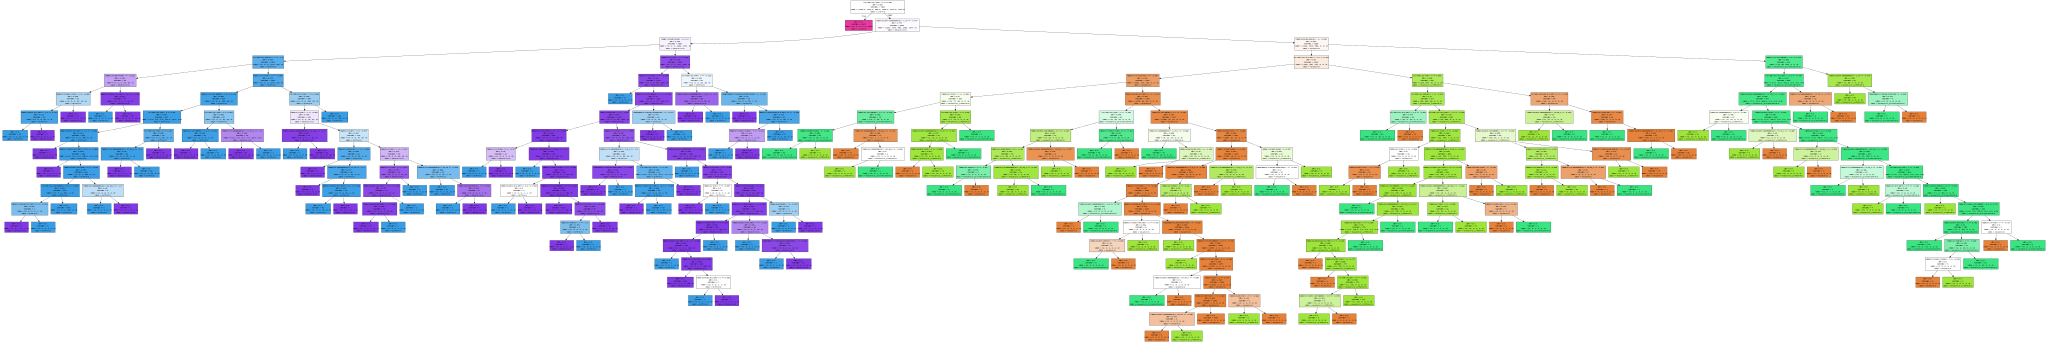

In [26]:
import graphviz

# 위에서 생성된 tree.dot 파일을 Graphviz 읽어서 Jupyter Notebook상에서 시각화
with open("tree.dot") as f:
    dot_graph = f.read()
graph = graphviz.Source(dot_graph)
graph

In [27]:
graph.render(filename='human_activity', directory='./', format='png')

'human_activity.png'

In [31]:
import warnings
warnings.filterwarnings('ignore')

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import pandas as pd

# 결정 트리에서 사용한 get_human_dataset( )을 이용해 학습/테스트용 DataFrame 반환
#X_train, X_test, y_train, y_test, feature_name = get_human_dataset()

# 랜덤 포레스트 학습 및 별도의 테스트 셋으로 예측 성능 평가
rf_clf = RandomForestClassifier(random_state=0)
rf_clf.fit(X_train , y_train)
pred = rf_clf.predict(X_test)

accuracy = accuracy_score(y_test , pred)
print('랜덤 포레스트 정확도: {0:.4f}'.format(accuracy))

랜덤 포레스트 정확도: 0.9223


# Cross Validation

In [32]:
from sklearn.model_selection import GridSearchCV

params = {
    'max_depth' : [ 6, 8 ,10, 12, 16 ,20, 24]
}

grid_cv = GridSearchCV(dt_clf, param_grid=params, scoring='accuracy', cv=5, verbose=1)
grid_cv.fit(X_train , y_train)

print('GridSearchCV 최고 평균 정확도 수치:{0:.4f}'.format(grid_cv.best_score_))
print('GridSearchCV 최적 하이퍼 파라미터:', grid_cv.best_params_)


Fitting 5 folds for each of 7 candidates, totalling 35 fits
GridSearchCV 최고 평균 정확도 수치:0.8512
GridSearchCV 최적 하이퍼 파라미터: {'max_depth': 10}


In [33]:
# GridSearchCV객체의 cv_results_ 속성을 DataFrame으로 생성.
cv_results_df = pd.DataFrame(grid_cv.cv_results_)

# max_depth 파라미터 값과 그때의 테스트(Evaluation)셋, 학습 데이터 셋의 정확도 수치 추출
cv_results_df[['param_max_depth', 'mean_test_score']]

,param_max_depth,mean_test_score
0,6,0.850791
1,8,0.851069
2,10,0.851209
3,12,0.844271
4,16,0.850255
5,20,0.850120
6,24,0.849168


In [34]:
max_depths = [ 6, 8 ,10, 12, 16 ,20, 24]

# max_depth 값을 변화 시키면서 그때마다 학습과 테스트 셋에서의 예측 성능 측정
for depth in max_depths:
    dt_clf = DecisionTreeClassifier(max_depth=depth, min_samples_split=16, random_state=156)
    dt_clf.fit(X_train , y_train)
    pred = dt_clf.predict(X_test)
    accuracy = accuracy_score(y_test , pred)
    print('max_depth = {0} 정확도: {1:.4f}'.format(depth , accuracy))

max_depth = 6 정확도: 0.8551
max_depth = 8 정확도: 0.8717
max_depth = 10 정확도: 0.8599
max_depth = 12 정확도: 0.8571
max_depth = 16 정확도: 0.8599
max_depth = 20 정확도: 0.8565
max_depth = 24 정확도: 0.8565


In [38]:
params = {
    'max_depth' : [ 8 , 12, 16 ,20],
    'min_samples_split' : [16, 24],
}

grid_cv = GridSearchCV(dt_clf, param_grid=params, scoring='accuracy', cv=5, verbose=1 )
grid_cv.fit(X_train , y_train)
print('GridSearchCV 최고 평균 정확도 수치: {0:.4f}'.format(grid_cv.best_score_))
print('GridSearchCV 최적 하이퍼 파라미터:', grid_cv.best_params_)


Fitting 5 folds for each of 8 candidates, totalling 40 fits
GridSearchCV 최고 평균 정확도 수치: 0.8549
GridSearchCV 최적 하이퍼 파라미터: {'max_depth': 8, 'min_samples_split': 16}


In [39]:
best_df_clf = grid_cv.best_estimator_
pred1 = best_df_clf.predict(X_test)
accuracy = accuracy_score(y_test , pred1)
print('결정 트리 예측 정확도:{0:.4f}'.format(accuracy))

결정 트리 예측 정확도:0.8717


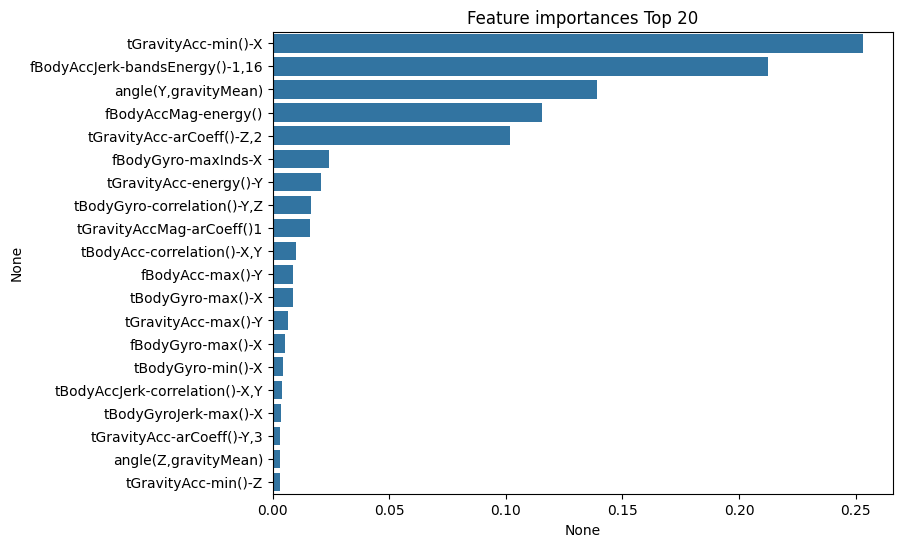

In [41]:
import seaborn as sns
import matplotlib.pyplot as plt

ftr_importances_values = best_df_clf.feature_importances_

# Top 중요도로 정렬을 쉽게 하고, 시본(Seaborn)의 막대그래프로 쉽게 표현하기 위해 Series변환
ftr_importances = pd.Series(ftr_importances_values, index=X_train.columns  )

# 중요도값 순으로 Series를 정렬
ftr_top20 = ftr_importances.sort_values(ascending=False)[:20]
plt.figure(figsize=(8,6))
plt.title('Feature importances Top 20')
sns.barplot(x=ftr_top20 , y = ftr_top20.index)
plt.show()